<div class="usecase-title">Bird Habitat Analysis T1 2024</div>

<div class="usecase-authors"><b>Authored by: </b>Katrine Chan</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python </div>
</div>

<div class="usecase-section-header">Scenario</div>

As a member of the council, I am eager to explore bird habitats within Melbourne city.  Imagine a city without birds! Bird habitats are not only a source of beauty and wonder but also a sign of a healty ecosystem, reflecting the quality of air, water and vegetation of a city.  A thorough analysis of bird habitats will enable us to identify critical habitats and biodiverstiy hotspots within Melbourne, guiding conservation priorities and land management decisions.  This investigation aligns closely with the mission to prioritise the environment and biodiversity in the City of Melbourne. Through this analysis, I aim to discover:

* The types of birds commonly found in the City of Melbourne using survey completed in 2018
* How changes in tree canopies or the basence may influence number of bird sightings
* How daily changes in average temperature changes the number of bird sightings
* Develop a model which can predict sighting of birds using machine learning techniuqes based on environmental variables such as availability of tree canopies, minimum temperature, maximum temperature and precipitation


<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
* Have gained an understanding of using APIs
* Have learned how to fetch datasets using APIs from Melbourne Open Data Database 
* Become familiar with performing data pre-processing
* Learned how to visualize real-life data using appropriate visualisation tools
* Learned how to work with various geospatial data processing and analysis tools  
* Learned how to encode categorical data types
* Learned how to normalise data
* Learned how to work with more than one dataset

<div class="usecase-section-header"><i><b>Introduction</i></b></div>

To complete our bird habitat analysis, two datasets will be used.  These datasets will include below:

* Bird survey result for areas in the city of Melbourne in February and March 2018 - 
The bird survey contains data from multiple river and wetland sites in Melbourne. Surveys were conducted by Ecology Australia during February and March 2018, recording species richness and numbers. 
* Tree canopies public realm 2018 (Urban Forest) - 
Tree canopy within City of Melbourne mapped using 2018 aerial photos and LiDAR. The canopy polygons represent actual tree canopy extents on public property (land managed by the City of Melbourne) across the city. 
* Climate Daily Summary 2018 from NOAA - 
The NOAA Climate Data Online(CDO) is a platform offering datasets for historical weather and climate.  The dataset which will be utilised include Daily Climate summary including precipitation, max temperature, min temperature and average.  Notably, this dataset was not available through the Melbourne Open Data database. Consequently, a CSV file was obtained directly from the NOAA database.

<p style="font-weight: bold; font-size: 1.2em;">Part 1 - Importing Modules</p>

In [2]:
# importing required modules required to complete this analysis

import requests
import pandas as pd
import numpy as np
from io import StringIO

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import folium
from folium.plugins import MousePosition

import geopandas as gpd
from shapely.geometry import Point
import json

from shapely.ops import nearest_points

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error, explained_variance_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV



<p style="font-weight: bold; font-size: 1.2em;">Part 2 - Retrieving Bird Survey Results from Melboure Open Data</p>



In [3]:
# Retrieving Bird Survey Data from Melbourne Open Data through the use of API

# https://data.melbourne.vic.gov.au/explore/dataset/bird-survey-results-for-areas-in-the-city-of-melbourne-february-and-march-2018/information/
dataset_id = 'bird-survey-results-for-areas-in-the-city-of-melbourne-february-and-march-2018'

base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
# apikey = ''
dataset_id = dataset_id
format = 'csv'

url = f'{base_url}{dataset_id}/exports/{format}'
params = {
    'select': '*',
    'limit': -1, # all records
    'lang': 'en',
    'timezone': 'UTC'
    #'api_key': apikey
}

#GET request 
response = requests.get(url, params = params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    birds_df = pd.read_csv(StringIO(url_content), delimiter= ';')
    print(birds_df.sample(10, random_state = 999))
else: 
    print(f'Request failed with status code{response.status_code}')

    sighting_date         common_name              scientific_name  \
194    2018-03-12       House Sparrow            Passer domesticus   
490    2018-02-15     Welcome Swallow        Petrochelidon neoxena   
253    2018-03-12   Superb Fairy-wren              Malurus cyaneus   
279    2018-03-12       Dusky Moorhen          Gallinula tenebrosa   
94     2018-02-15       Chestnut Teal                Anas castanea   
151    2018-02-15  Australasian Grebe  Tachybaptus novaehollandiae   
233    2018-02-15   Little Wattlebird      Anthochaera chrysoptera   
124    2018-03-19    Rainbow Lorikeet     Trichoglossus haematodus   
457    2018-03-19      Red Wattlebird      Anthochaera carunculata   
211    2018-03-12           Rock Dove                Columba livia   

     sighting_count  victorian_biodiversity_atlas_code      lat       lon  \
194              18                              10995 -37.8038  144.9118   
490              14                              10357 -37.7792  144.9482  

In [4]:
# obtaining the shape of the birds survey data frame and printing out the number of rows and columns in the birds dataframe 
num_rows, num_cols = birds_df.shape

print("Number of rows in the birds_df is:", num_rows)
print("Number of columns in the birds_df is:", num_cols)

# printing out the first 10 observations in dataframe to understand the information the dataframe contains
birds_df.head(10)

Number of rows in the birds_df is: 498
Number of columns in the birds_df is: 14


,sighting_date,common_name,scientific_name,sighting_count,victorian_biodiversity_atlas_code,lat,lon,loc1_desc,lat2,lon2,loc2_desc,site_name,location_2,location_1
0,2018-03-12,Australian Magpie,Gymnorhina tibicen,2,10705,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,NaN,NaN,NaN,Dynon Road Tidal Canal Wildlife Sanctuary,NaN,"-37.8038, 144.9118"
1,2018-02-28,Australian White Ibis,Threskiornis molucca,141,10179,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,NaN,NaN,NaN,Dynon Road Tidal Canal Wildlife Sanctuary,NaN,"-37.8038, 144.9118"
2,2018-03-12,Australian White Ibis,Threskiornis molucca,83,10179,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,NaN,NaN,NaN,Dynon Road Tidal Canal Wildlife Sanctuary,NaN,"-37.8038, 144.9118"
3,2018-02-28,Chestnut Teal,Anas castanea,7,10210,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,NaN,NaN,NaN,Dynon Road Tidal Canal Wildlife Sanctuary,NaN,"-37.8038, 144.9118"
4,2018-03-12,Chestnut Teal,Anas castanea,5,10210,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,NaN,NaN,NaN,Dynon Road Tidal Canal Wildlife Sanctuary,NaN,"-37.8038, 144.9118"
5,2018-03-06,Common Blackbird,Turdus merula,1,10991,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,NaN,NaN,NaN,Dynon Road Tidal Canal Wildlife Sanctuary,NaN,"-37.8038, 144.9118"
6,2018-03-19,Common Blackbird,Turdus merula,3,10991,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,NaN,NaN,NaN,Dynon Road Tidal Canal Wildlife Sanctuary,NaN,"-37.8038, 144.9118"
7,2018-02-15,Common Myna,Acridotheres tristis,36,10998,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,NaN,NaN,NaN,Dynon Road Tidal Canal Wildlife Sanctuary,NaN,"-37.8038, 144.9118"
8,2018-02-15,Common Starling,Sturnus vulgaris,3,10999,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,NaN,NaN,NaN,Dynon Road Tidal Canal Wildlife Sanctuary,NaN,"-37.8038, 144.9118"
9,2018-03-19,Common Starling,Sturnus vulgaris,0,10999,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,NaN,NaN,NaN,Dynon Road Tidal Canal Wildlife Sanctuary,NaN,"-37.8038, 144.9118"


<p style="font-weight: bold; font-size: 1.2em;">Part 3 - Pre-processing of birds_df</p>

In [5]:
# Looking at the birds_df, there are features which can be dropped, 
# these includes lat2 lon2 loc2_desc site_name location_2 location_1
# these contain the same information as other existing data and therefore 
# will be dropped

columns_to_drop = ['lat2', 'lon2', 'loc2_desc', 'site_name', 'location_2', 'location_1']
birds_df = birds_df.drop(columns=columns_to_drop)

birds_df


,sighting_date,common_name,scientific_name,sighting_count,victorian_biodiversity_atlas_code,lat,lon,loc1_desc
0,2018-03-12,Australian Magpie,Gymnorhina tibicen,2,10705,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...
1,2018-02-28,Australian White Ibis,Threskiornis molucca,141,10179,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...
2,2018-03-12,Australian White Ibis,Threskiornis molucca,83,10179,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...
3,2018-02-28,Chestnut Teal,Anas castanea,7,10210,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...
4,2018-03-12,Chestnut Teal,Anas castanea,5,10210,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...
...,...,...,...,...,...,...,...,...
493,2018-02-20,Pacific Black Duck,Anas superciliosa,4,10208,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...
494,2018-02-20,Magpie-lark,Grallina cyanoleuca,13,10415,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...
495,2018-02-20,Red Wattlebird,Anthochaera carunculata,10,10638,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...
496,2018-02-20,Australian Magpie,Gymnorhina tibicen,4,10705,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...


In [6]:
# Checking for missing values in the birds_df 

missing_values = birds_df.isna().sum()
print(missing_values)


sighting_date                        0
common_name                          0
scientific_name                      0
sighting_count                       0
victorian_biodiversity_atlas_code    0
lat                                  0
lon                                  0
loc1_desc                            0
dtype: int64


This shows that there are no missing values in the dataframe 

<p style="font-weight: bold; font-size: 1.2em;">Part 4 - Exploratory Data Analysis on birds_df</p>


In [7]:
# Finding the date range of the dataset
earliest_date = birds_df['sighting_date'].min()
latest_date = birds_df['sighting_date'].max()

# Displaying the date range
print("Date range for the birds_df:")
print("Earliest date:", earliest_date)
print("Latest date:", latest_date)


Date range for the birds_df:
Earliest date: 2018-02-15
Latest date: 2018-03-19


This confirms that the observation period for the bird survey started on 15th Feb 2018 and finishes on 19th March 2018.

In [8]:
# Counting number of unique bird species
num_unique = birds_df['common_name'].nunique()

# Display the number of unique bird species 
print("Number of unique bird species sighted:", num_unique)

# Display the unique bird species 
unique_values = birds_df['common_name'].unique()
print("\nUnique Bird Species:")
print(unique_values)

# Calculating the total number of bird sightings 
total_sights = birds_df['sighting_count'].sum()
print("\nTotal number of bird sightings:", total_sights)


Number of unique bird species sighted: 50

Unique Bird Species:
['Australian Magpie' 'Australian White Ibis' 'Chestnut Teal'
 'Common Blackbird' 'Common Myna' 'Common Starling' 'Dusky Moorhen'
 'Eastern Great Egret' 'Little Pied Cormorant' 'Little Raven'
 'Little Wattlebird' 'Magpie-lark' 'Musk Lorikeet' 'Nankeen Night Heron'
 'New Holland Honeyeater' 'Pacific Black Duck' 'Rainbow Lorikeet'
 'Red Wattlebird' 'Rock Dove' 'Spotted Turtle-Dove' 'Superb Fairy-wren'
 'White-plumed Honeyeater' 'Willie Wagtail' 'Clamorous Reed Warbler'
 'House Sparrow' 'Noisy Miner' 'White-faced Heron' 'Black Swan'
 'Brown Thornbill' 'Darter' 'Eurasian Coot' 'Grey Teal'
 'Hoary-headed Grebe' 'Little Black Cormorant'
 'Phylidonyris novaehollandiae' 'Silver Gull' 'Welcome Swallow'
 'White-browed Scrubwren' 'Hardhead' 'Australasian Grebe' 'Bell Miner'
 'Tree Martin' 'Crested Tern' 'European Greenfinch' 'Australian Wood Duck'
 'Masked Lapwing' 'Red-rumped Parrot' 'Great Cormorant'
 'Spotted Pardalote' 'Crested Pi

During the survey period, 50 unique bird species were observed, with a total sightings of 6712 birds. 

In [9]:
# calculating the sum of sight_count of each unique bird species
sight_count_totals = birds_df.groupby('common_name')['sighting_count'].sum()

# Displaying the total of each bird species
print("Total sight count for each type of bird species from 15-02-2018 to 19-03-2018:")
print(sight_count_totals)


Total sight count for each type of bird species from 15-02-2018 to 19-03-2018:
common_name
Australasian Grebe                10
Australian Magpie                 20
Australian White Ibis            471
Australian Wood Duck               1
Bell Miner                         8
Black Swan                         6
Brown Thornbill                    6
Chestnut Teal                    364
Clamorous Reed Warbler            11
Common Blackbird                  46
Common Myna                      539
Common Starling                  141
Crested Pigeon                    58
Crested Tern                       1
Darter                             2
Dusky Moorhen                     21
Eastern Great Egret                4
Eurasian Coot                      9
European Greenfinch                1
Great Cormorant                   22
Grey Teal                         69
Hardhead                           7
Hoary-headed Grebe                 1
House Sparrow                    420
Little Black Cormoran

In [10]:
# sort sight count from largest to smallest
sorted_sight_count_totals = sight_count_totals.sort_values(ascending=False)

# Printing the sorted list
print("Total sight count for each bird (sorted by largest to smallest):")
print(sorted_sight_count_totals)


Total sight count for each bird (sorted by largest to smallest):
common_name
Silver Gull                     1311
Rock Dove                       1308
Common Myna                      539
Australian White Ibis            471
House Sparrow                    420
White-plumed Honeyeater          370
Chestnut Teal                    364
Spotted Turtle-Dove              317
Little Raven                     165
Common Starling                  141
Little Wattlebird                118
Red Wattlebird                   104
Superb Fairy-wren                101
Pacific Black Duck                92
Magpie-lark                       90
Rainbow Lorikeet                  88
Little Pied Cormorant             77
Grey Teal                         69
New Holland Honeyeater            67
Little Black Cormorant            65
Crested Pigeon                    58
Willie Wagtail                    48
Common Blackbird                  46
Musk Lorikeet                     38
Noisy Miner                       3

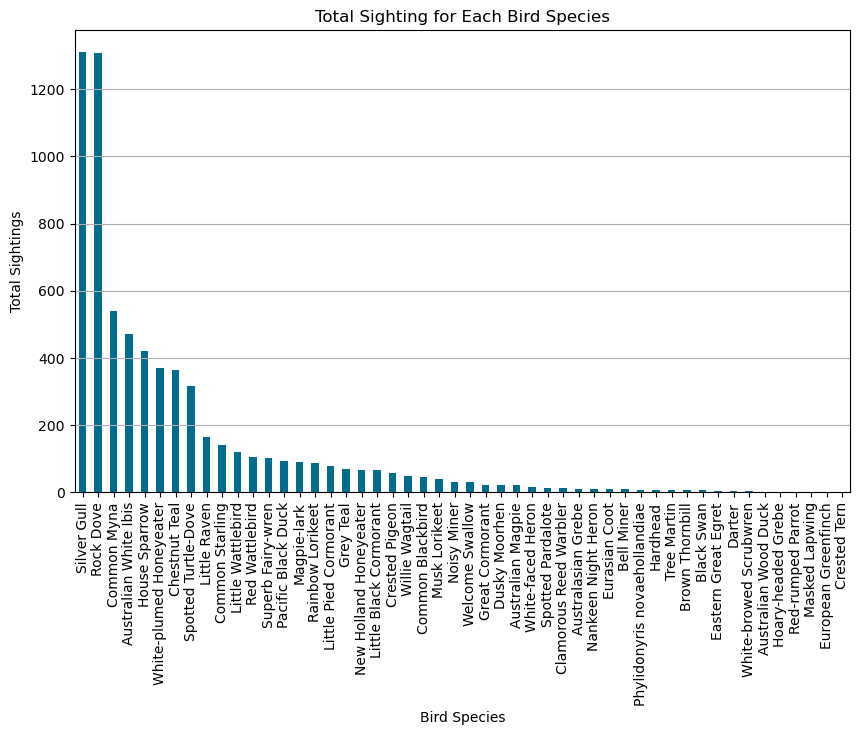

In [11]:

# Plotting the sightings for each bird species from largest to smallest
plt.figure(figsize=(10, 6))
sorted_sight_count_totals.plot(kind='bar', color='#056b8a')
plt.title('Total Sighting for Each Bird Species')
plt.xlabel('Bird Species')
plt.ylabel('Total Sightings')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines for y-axis
plt.show()


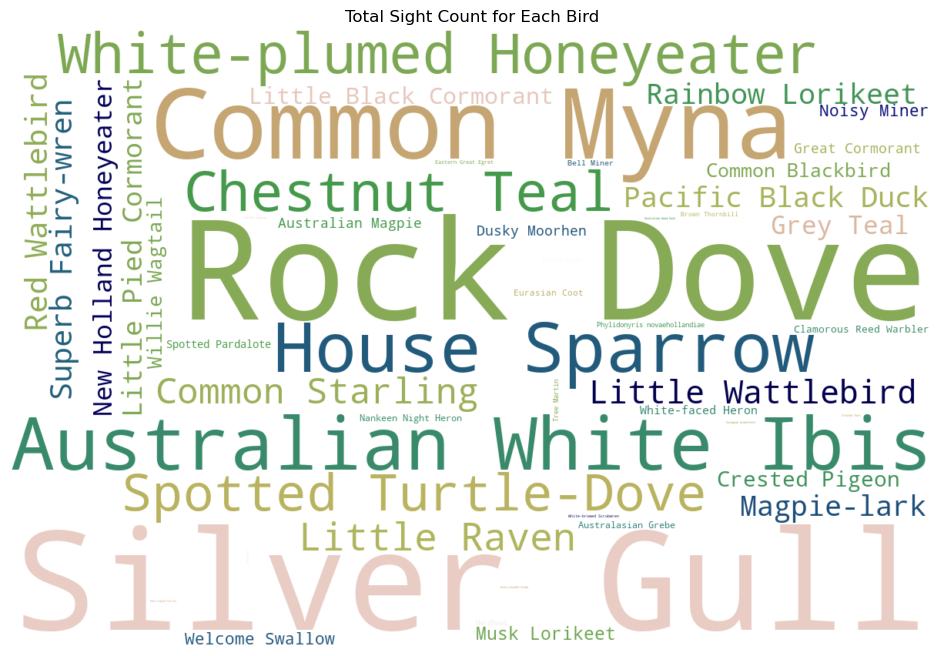

In [12]:
# WordCloud chart - an alternative way to display the most sighted bird species through the survey period

# creating a dict to have bird species as keys and counts as values
sight_count_dict = sorted_sight_count_totals.to_dict()

# creating wordcloud instance
wordcloud = WordCloud(width=1200, 
                      height=800, 
                      background_color='white',
                      colormap = 'gist_earth')

# generates word cloud from frequences in the dict
wordcloud.generate_from_frequencies(sight_count_dict)


plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Total Sight Count for Each Bird')
plt.show()


The most frequently observed bird species during the survey period were the Silver Gull and Rock Dove, with 1311 and 1308 sightings, respectively. The least observed species, each with only a single sighting throughout the entire survey period, were the Australian Wood Duck, Hoary-headed Grebe, Red-rumped Parrot, Masked Lapwing, European Greenfinch, and Crested Tern.

In [13]:
# finding the unique latitude and longtitude pairs indicating the locations of these sightings
unique_lat_lon = birds_df[['lat', 'lon']].drop_duplicates()
unique_lat_lon

,lat,lon
0,-37.8038,144.9118
45,-37.8028,144.9249
88,-37.8054,144.9364
142,-37.8008,144.9099
151,-37.7792,144.9482
162,-37.8138,144.8727


6 unique locations were identified.  

In [14]:

# Create a map centered at a specific location
my_map = folium.Map(location=[-37.81141, 144.9258], zoom_start=13)  # Somewhere in West Melb to centred the map around birds sightings

# Group by latitude and longitude, and sum up the sighting counts
grouped_data = birds_df.groupby(['lat', 'lon'])['sighting_count'].sum().reset_index()

# Creating markers - to show the total bird counts in the specific location  
for index, row in grouped_data.iterrows():
    total_bird_counts = row['sighting_count']
    tooltip_text = f'Total Bird Count: {total_bird_counts}'
    folium.Marker([row['lat'], row['lon']], tooltip=tooltip_text).add_to(my_map)

# MousePosition to show coordinate when mouse hover over the map
#MousePosition().add_to(my_map)

# Display map
my_map

<p style="font-weight: bold; font-size: 1.2em;">Part 5 - Retrieving Tree Canopies 2018 Data from Melboure Open Data</p>

In [15]:
# https://data.melbourne.vic.gov.au/explore/dataset/tree-canopies-public-realm-2018-urban-forest/information/
dataset_id = 'tree-canopies-public-realm-2018-urban-forest'

base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
# apikey = ''
dataset_id = dataset_id
format = 'csv'

url = f'{base_url}{dataset_id}/exports/{format}'
params = {
    'select': '*',
    'limit': -1, # all records
    'lang': 'en',
    'timezone': 'UTC'
    #'api_key': apikey
}

#GET request 
response = requests.get(url, params = params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    canopies_df = pd.read_csv(StringIO(url_content), delimiter= ';')
    print(canopies_df.sample(10, random_state = 999))
else: 
    print(f'Request failed with status code{response.status_code}')

                                  geo_point_2d  \
4993   -37.789245487248955, 144.94907327748658   
31513   -37.78846374389525, 144.95420928619802   
18171    -37.80692169787488, 144.9118117646351   
7396    -37.83596676660426, 144.98204783875804   
31227    -37.78449294222701, 144.9578644584792   
20428   -37.82450732516304, 144.97277931148116   
4737    -37.79066825673181, 144.96852564886908   
4481     -37.79166297370613, 144.9467889348235   
29950  -37.786052378475034, 144.94211772681197   
20014  -37.827161332727364, 144.95396048362198   

                                               geo_shape  objectid  \
4993   {"coordinates": [[[[144.94902392357957, -37.78...     26783   
31513  {"coordinates": [[[[144.95420648034033, -37.78...     27535   
18171  {"coordinates": [[[[144.91183016948642, -37.80...     13420   
7396   {"coordinates": [[[[144.98205287385025, -37.83...      1304   
31227  {"coordinates": [[[[144.95787040149435, -37.78...     29225   
20428  {"coordinates": [[[[14

In [16]:
# obtaining the shape of the canopies 2018 data frame and printing out the number of rows and columns in the canopies dataframe 
num_rows, num_cols = canopies_df.shape

print("Number of rows in the canopies_df is:", num_rows)
print("Number of columns in the canopies_df is:", num_cols)

# printing out the first 10 observations in dataframe to understand the information the dataframe contains
canopies_df.head(10)

Number of rows in the canopies_df is: 32787
Number of columns in the canopies_df is: 5


,geo_point_2d,geo_shape,objectid,shape_leng,shape_area
0,"-37.78645081161359, 144.9457948486621","{""coordinates"": [[[[144.9458032369502, -37.786...",28424,9.758772,7.146249
1,"-37.78665289265347, 144.95688839987147","{""coordinates"": [[[[144.95688796441414, -37.78...",28427,25.145322,39.658550
2,"-37.78634183331809, 144.9437100316845","{""coordinates"": [[[[144.94371952530884, -37.78...",28447,6.545899,2.960294
3,"-37.78645783366489, 144.94630436225728","{""coordinates"": [[[[144.9463102465029, -37.786...",28436,19.817709,21.555092
4,"-37.78660663588553, 144.9527556191466","{""coordinates"": [[[[144.95283728640467, -37.78...",28440,81.959875,284.081588
5,"-37.786335429910025, 144.9418244644021","{""coordinates"": [[[[144.94183055252876, -37.78...",28441,3.709592,0.999001
6,"-37.78639375723135, 144.94607838964833","{""coordinates"": [[[[144.94608601536297, -37.78...",28445,5.382447,2.131346
7,"-37.786543214365906, 144.95654083974642","{""coordinates"": [[[[144.95654581041998, -37.78...",28453,2.606254,0.460448
8,"-37.786254327925114, 144.94180926853593","{""coordinates"": [[[[144.9418154254935, -37.786...",28466,3.592320,0.903463
9,"-37.786693200794694, 144.9631233333797","{""coordinates"": [[[[144.96315334980625, -37.78...",28454,30.663307,52.855833


Based on the data, there were a total of 32,787 tree canopies across the city of Melbourne in the year of 2018. 

<p style="font-weight: bold; font-size: 1.2em;">Part 6 - Pre-processing Tree Canopies 2018 Data from Melboure Open Data</p>

In [17]:
# Checking for missing values in canopies_df
missing_values = canopies_df.isna().sum()
print(missing_values)

geo_point_2d    0
geo_shape       2
objectid        0
shape_leng      0
shape_area      0
dtype: int64


There are two missing values under geo_shape, further exploration is required to determine the appropriate course of action. 

In [18]:
# print out the rows with missing observations under geo_shape column
print(canopies_df[canopies_df['geo_shape'].isna()])

                                  geo_point_2d geo_shape  objectid  \
5222   -37.792210395218454, 144.93217446167108       NaN     24393   
19645   -37.83559414630663, 144.98132315453557       NaN      1382   

       shape_leng  shape_area  
5222     1.556349    0.011321  
19645    1.382046    0.020725  


Since there are only two observsations out of the 32,787 total, and it is not feasible to replace the missing values with the median or average of other geo_shape, it has been determined that these two observations will be dropped from the dataset. 

In [19]:
# dropping the two observations with missing values under geo_shape
canopies_df = canopies_df.dropna()

# Checking again for missing values
missing_values = canopies_df.isna().sum()
print(missing_values)


geo_point_2d    0
geo_shape       0
objectid        0
shape_leng      0
shape_area      0
dtype: int64


The canopies_df now contains no missing values. 

In [20]:
# Below codes can be used to plot the 32,785 canopies geo_shape on a map, 
# however, due to the large size (160MB) this plot will not be plotted. 
# To plot the map, remove ''' at the start and the end of the code  

'''
# Plotting geo-shapes

# Create a map centered at a specific location
my_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)  # Melbourne

# defining style of map
def style_function(feature):
    return {
        'fillColor': 'blue',
        'color': None,
        'fillOpacity': 0.5
    }

# going through each row to retrieves each geo_shape and assign it to geo_shape_value
for index, row in canopies_df.iterrows():
    geo_shape_value = row['geo_shape']
    
    # using geo_shape_value create each geoshape
    folium.GeoJson(geo_shape_value, style_function= style_function).add_to(my_map)

my_map
'''

"\n# Plotting geo-shapes\n\n# Create a map centered at a specific location\nmy_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)  # Melbourne\n\n# defining style of map\ndef style_function(feature):\n    return {\n        'fillColor': 'blue',\n        'color': None,\n        'fillOpacity': 0.5\n    }\n\n# going through each row to retrieves each geo_shape and assign it to geo_shape_value\nfor index, row in canopies_df.iterrows():\n    geo_shape_value = row['geo_shape']\n    \n    # using geo_shape_value create each geoshape\n    folium.GeoJson(geo_shape_value, style_function= style_function).add_to(my_map)\n\nmy_map\n"

<p style="font-weight: bold; font-size: 1.2em;">Part 7 - Merging the birds_df and canopies_df</p>


In [21]:
# Create a geometry column in birds_df using the lon and lat as Point geometries to enable the merge with canopies_df
birds_df['geometry'] = birds_df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# creating a geodataframe with the EPSG:4326 coordinate reference system 
birds_gdf = gpd.GeoDataFrame(birds_df, geometry='geometry', crs='EPSG:4326') # coordinate reference system 

birds_gdf


,sighting_date,common_name,scientific_name,sighting_count,victorian_biodiversity_atlas_code,lat,lon,loc1_desc,geometry
0,2018-03-12,Australian Magpie,Gymnorhina tibicen,2,10705,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380)
1,2018-02-28,Australian White Ibis,Threskiornis molucca,141,10179,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380)
2,2018-03-12,Australian White Ibis,Threskiornis molucca,83,10179,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380)
3,2018-02-28,Chestnut Teal,Anas castanea,7,10210,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380)
4,2018-03-12,Chestnut Teal,Anas castanea,5,10210,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380)
...,...,...,...,...,...,...,...,...,...
493,2018-02-20,Pacific Black Duck,Anas superciliosa,4,10208,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380)
494,2018-02-20,Magpie-lark,Grallina cyanoleuca,13,10415,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380)
495,2018-02-20,Red Wattlebird,Anthochaera carunculata,10,10638,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380)
496,2018-02-20,Australian Magpie,Gymnorhina tibicen,4,10705,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380)


In [22]:
# Preparing the canopies_df for the merge 

# As the geo_shape is provided in a GeoJaSON form, a function is required 
# to convert GeoJSON strings to GeoPandas geometries
def parse_geojson(geojson_string):
    geo_df = gpd.read_file(geojson_string) #taking the geostring as input and read using gpd
    geometry = geo_df.geometry #then extracting the geometry using .geometry
    return geometry

# applying above function to the geo_shape column with the geojson
canopies_df.loc[:, 'geometry'] = canopies_df['geo_shape'].apply(parse_geojson)

# new gdf ready for merge 
canopies_gdf = gpd.GeoDataFrame(canopies_df.copy(), geometry='geometry')

canopies_gdf



,geo_point_2d,geo_shape,objectid,shape_leng,shape_area,geometry
0,"-37.78645081161359, 144.9457948486621","{""coordinates"": [[[[144.9458032369502, -37.786...",28424,9.758772,7.146249,"MULTIPOLYGON (((144.94580 -37.78644, 144.94581..."
1,"-37.78665289265347, 144.95688839987147","{""coordinates"": [[[[144.95688796441414, -37.78...",28427,25.145322,39.658550,"MULTIPOLYGON (((144.95689 -37.78662, 144.95689..."
2,"-37.78634183331809, 144.9437100316845","{""coordinates"": [[[[144.94371952530884, -37.78...",28447,6.545899,2.960294,"MULTIPOLYGON (((144.94372 -37.78634, 144.94372..."
3,"-37.78645783366489, 144.94630436225728","{""coordinates"": [[[[144.9463102465029, -37.786...",28436,19.817709,21.555092,"MULTIPOLYGON (((144.94631 -37.78643, 144.94631..."
4,"-37.78660663588553, 144.9527556191466","{""coordinates"": [[[[144.95283728640467, -37.78...",28440,81.959875,284.081588,"MULTIPOLYGON (((144.95284 -37.78654, 144.95284..."
...,...,...,...,...,...,...
32782,"-37.78852115980117, 144.92333931648147","{""coordinates"": [[[[144.92333538171314, -37.78...",26881,4.160520,1.348466,"MULTIPOLYGON (((144.92334 -37.78853, 144.92333..."
32783,"-37.78929070901521, 144.95745545160335","{""coordinates"": [[[[144.95736874757412, -37.78...",26882,139.892778,510.827677,"MULTIPOLYGON (((144.95737 -37.78911, 144.95737..."
32784,"-37.78886861465895, 144.94305873505778","{""coordinates"": [[[[144.94306096662646, -37.78...",26884,8.119396,5.232788,"MULTIPOLYGON (((144.94306 -37.78888, 144.94306..."
32785,"-37.78899424455072, 144.94820633130126","{""coordinates"": [[[[144.94824564679345, -37.78...",26885,33.770666,28.128738,"MULTIPOLYGON (((144.94825 -37.78897, 144.94824..."


Both the birds_df and canopies_df have now been converted to GeoDataFrames ready for merging using relevant spatial information. 

In [23]:
# Error message without these so below were added. 
birds_gdf.crs = 'EPSG:4326'
canopies_gdf.crs = 'EPSG:4326'


# Perform spatial join using the birds_gdf and canopies_gdf created above
# left is used retaining all results from birds_gdf
# parameter op within checks if points in birds_gdf are within multipolygons in canopies gdf
joined_df = gpd.sjoin(birds_gdf, canopies_gdf, how='left', predicate='within')

# Add column to indicate if a point is within a canopy
joined_df['within_canopy'] = ~joined_df['index_right'].isnull()

joined_df



,sighting_date,common_name,scientific_name,sighting_count,victorian_biodiversity_atlas_code,lat,lon,loc1_desc,geometry,index_right,geo_point_2d,geo_shape,objectid,shape_leng,shape_area,within_canopy
0,2018-03-12,Australian Magpie,Gymnorhina tibicen,2,10705,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380),12796.0,"-37.80376975866237, 144.91199777799773","{""coordinates"": [[[[144.9121005094701, -37.803...",14896.0,197.010186,564.959986,True
1,2018-02-28,Australian White Ibis,Threskiornis molucca,141,10179,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380),12796.0,"-37.80376975866237, 144.91199777799773","{""coordinates"": [[[[144.9121005094701, -37.803...",14896.0,197.010186,564.959986,True
2,2018-03-12,Australian White Ibis,Threskiornis molucca,83,10179,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380),12796.0,"-37.80376975866237, 144.91199777799773","{""coordinates"": [[[[144.9121005094701, -37.803...",14896.0,197.010186,564.959986,True
3,2018-02-28,Chestnut Teal,Anas castanea,7,10210,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380),12796.0,"-37.80376975866237, 144.91199777799773","{""coordinates"": [[[[144.9121005094701, -37.803...",14896.0,197.010186,564.959986,True
4,2018-03-12,Chestnut Teal,Anas castanea,5,10210,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380),12796.0,"-37.80376975866237, 144.91199777799773","{""coordinates"": [[[[144.9121005094701, -37.803...",14896.0,197.010186,564.959986,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2018-02-20,Pacific Black Duck,Anas superciliosa,4,10208,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380),NaN,NaN,NaN,NaN,NaN,NaN,False
494,2018-02-20,Magpie-lark,Grallina cyanoleuca,13,10415,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380),NaN,NaN,NaN,NaN,NaN,NaN,False
495,2018-02-20,Red Wattlebird,Anthochaera carunculata,10,10638,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380),NaN,NaN,NaN,NaN,NaN,NaN,False
496,2018-02-20,Australian Magpie,Gymnorhina tibicen,4,10705,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380),NaN,NaN,NaN,NaN,NaN,NaN,False


Both the birds_df and canopies_df have now been merged into a single dataframe named joined_df for further analysis. 

<p style="font-weight: bold; font-size: 1.2em;">Part 8 - Exploring and Cleansing the new joined Dataframe joined_df</p>


In [24]:
# obtaining the shape of the joined_df survey data frame and printing out the number of rows and columns 
num_rows, num_cols = joined_df.shape

print("Number of rows in the joined_df is:", num_rows)
print("Number of columns in the joined_df is:", num_cols)

# printing out the first 10 observations in dataframe to understand the information the dataframe contains
birds_df.head(10)

Number of rows in the joined_df is: 498
Number of columns in the joined_df is: 16


,sighting_date,common_name,scientific_name,sighting_count,victorian_biodiversity_atlas_code,lat,lon,loc1_desc,geometry
0,2018-03-12,Australian Magpie,Gymnorhina tibicen,2,10705,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.9118 -37.8038)
1,2018-02-28,Australian White Ibis,Threskiornis molucca,141,10179,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.9118 -37.8038)
2,2018-03-12,Australian White Ibis,Threskiornis molucca,83,10179,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.9118 -37.8038)
3,2018-02-28,Chestnut Teal,Anas castanea,7,10210,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.9118 -37.8038)
4,2018-03-12,Chestnut Teal,Anas castanea,5,10210,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.9118 -37.8038)
5,2018-03-06,Common Blackbird,Turdus merula,1,10991,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.9118 -37.8038)
6,2018-03-19,Common Blackbird,Turdus merula,3,10991,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.9118 -37.8038)
7,2018-02-15,Common Myna,Acridotheres tristis,36,10998,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.9118 -37.8038)
8,2018-02-15,Common Starling,Sturnus vulgaris,3,10999,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.9118 -37.8038)
9,2018-03-19,Common Starling,Sturnus vulgaris,0,10999,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.9118 -37.8038)


In [25]:
# printing out features(column) in the joined_df
print(joined_df.columns.tolist())

['sighting_date', 'common_name', 'scientific_name', 'sighting_count', 'victorian_biodiversity_atlas_code', 'lat', 'lon', 'loc1_desc', 'geometry', 'index_right', 'geo_point_2d', 'geo_shape', 'objectid', 'shape_leng', 'shape_area', 'within_canopy']


In [26]:
# There are columns which hold duplicated infroamtion and therefore these will be dropped
columns_to_drop = ['victorian_biodiversity_atlas_code', 
                   'index_right', 
                   'objectid',
                   'scientific_name']
joined_df = joined_df.drop(columns=columns_to_drop)

# Replace NaN values in 'shape_leng' and 'shape_are' columns with 0, where 'geo_points' do not fall into a geo_shape
joined_df['shape_leng'].fillna(0, inplace=True)
joined_df['shape_area'].fillna(0, inplace=True)

joined_df


,sighting_date,common_name,sighting_count,lat,lon,loc1_desc,geometry,geo_point_2d,geo_shape,shape_leng,shape_area,within_canopy
0,2018-03-12,Australian Magpie,2,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380),"-37.80376975866237, 144.91199777799773","{""coordinates"": [[[[144.9121005094701, -37.803...",197.010186,564.959986,True
1,2018-02-28,Australian White Ibis,141,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380),"-37.80376975866237, 144.91199777799773","{""coordinates"": [[[[144.9121005094701, -37.803...",197.010186,564.959986,True
2,2018-03-12,Australian White Ibis,83,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380),"-37.80376975866237, 144.91199777799773","{""coordinates"": [[[[144.9121005094701, -37.803...",197.010186,564.959986,True
3,2018-02-28,Chestnut Teal,7,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380),"-37.80376975866237, 144.91199777799773","{""coordinates"": [[[[144.9121005094701, -37.803...",197.010186,564.959986,True
4,2018-03-12,Chestnut Teal,5,-37.8038,144.9118,Dynon Road Tidal Canal Wildlife Sanctuary Down...,POINT (144.91180 -37.80380),"-37.80376975866237, 144.91199777799773","{""coordinates"": [[[[144.9121005094701, -37.803...",197.010186,564.959986,True
...,...,...,...,...,...,...,...,...,...,...,...,...
493,2018-02-20,Pacific Black Duck,4,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380),NaN,NaN,0.000000,0.000000,False
494,2018-02-20,Magpie-lark,13,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380),NaN,NaN,0.000000,0.000000,False
495,2018-02-20,Red Wattlebird,10,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380),NaN,NaN,0.000000,0.000000,False
496,2018-02-20,Australian Magpie,4,-37.8138,144.8727,Stony Creek at Upstream limit near Julian Stre...,POINT (144.87270 -37.81380),NaN,NaN,0.000000,0.000000,False


In [27]:
# Creating a map showing bird sighting points and the relevant geoshapes which they fall into

# Create a map centered at a specific location
my_map = folium.Map(location=[-37.81141, 144.9258], zoom_start=13)  # Somewhere in West Melb to centred the map around birds sightings

# Group by latitude and longitude, and sum up the sighting counts
grouped_data = birds_df.groupby(['lat', 'lon'])['sighting_count'].sum().reset_index()

# Creating markers - to show the total bird counts in the specific location  
for index, row in grouped_data.iterrows():
    total_bird_counts = row['sighting_count']
    tooltip_text = f'Total Bird Count: {total_bird_counts}'
    folium.Marker([row['lat'], row['lon']], tooltip=tooltip_text).add_to(my_map)
    
# Getting the unique geo_shape values from the joined_df and also dropping any NaN values
unique_geo_shapes = joined_df['geo_shape'].dropna().unique()

# Printing out the unique geo_shapes and adding to map
for geo_shape in unique_geo_shapes:
    geo_json = folium.GeoJson(geo_shape)
    geo_json.add_to(my_map)

my_map

This map illustrates that out of the six sighting locations, only two are situated within a tree canopy area. 